# Quickstart

Start with `Flower Datasets` as fast as possible by learning the essentials.

In [2]:
!python --version

Python 3.12.11


每次启动都要重新运行安装各种包，下面这行运行两遍才能成功

In [6]:
!pip install -q flwr[simulation] flwr-datasets[vision] torch torchvision matplotlib

In [7]:
from collections import OrderedDict
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar
from torch.utils.data import DataLoader

import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation
from flwr_datasets import FederatedDataset

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
disable_progress_bar()

Training on cpu
Flower 1.20.0 / PyTorch 2.8.0+cu126


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


## Install Flower Datasets

In [8]:
! pip install -q "flwr-datasets[vision]"

If you want to use audio datasets install:

```bash
! pip install -q "flwr-datasets[audio]"
```

flag1-25-9-4

## Choose the dataset

To choose the dataset, go to Hugging Face [Datasets Hub](https://huggingface.co/datasets) and search for your dataset by name. You will pass that names to the `dataset` parameter of `FederatedDataset`. Note that the name is case-sensitive.

<div style="max-width:80%; margin-left: auto; margin-right: auto;">
  <img src="https://github.com/fycq22/flower/blob/main/datasets/docs/source/_static/tutorial-quickstart/choose-hf-dataset.png?raw=1" alt="Choose HF dataset."/>
</div>

Note that once the dataset is available on HuggingFace Hub it can be immediately used in `Flower Datasets` (no approval from Flower team is needed, no custom code needed).

Here is how it looks for `CIFAR10` dataset.

<div style="max-width:80%; margin-left: auto; margin-right: auto;">
  <img src="https://github.com/fycq22/flower/blob/main/datasets/docs/source/_static/tutorial-quickstart/copy-dataset-name.png?raw=1" alt="Choose HF dataset."/>
</div>

## Partition the dataset

To partition a dataset (in a basic scenario), you need to choose two things:
1) A dataset (identified by a name),
2) A partitioning scheme (by selecting one of the supported partitioning schemes, [see all of them here](https://flower.ai/docs/datasets/ref-api/flwr_datasets.partitioner.html), or creating a custom partitioning scheme).



**1) Dataset choice**

We will pass the name of the dataset to `FederatedDataset(dataset="some-name", other-parameters)`. In this example it will be: `FederatedDataset(dataset="uoft-cs/cifar10", other-parameters)`

**2) Partitioner choice**

We will partition the dataset in an IID manner using `IidPartitioner` ([link to the docs](https://flower.ai/docs/datasets/ref-api/flwr_datasets.partitioner.IidPartitioner.html#flwr_datasets.partitioner.IidPartitioner)).
Only the train split of the dataset will be processed. In general, we do `FederatedDataset(dataset="some-name", partitioners={"split-name": partitioning_scheme})`, which for this example looks like:

由于我们只有一个csv文件，因此需要自己划分测试集和训练集。此外我们还需要把Label从value修改为Classlabel。

In [12]:
from flwr_datasets import FederatedDataset
from flwr_datasets.partitioner import IidPartitioner
from datasets import ClassLabel
import numpy as np

# 创建 FederatedDataset，只对 train 做分区
fds = FederatedDataset(
    dataset="fycq22/CICIDS-171819",
    partitioners={"train": IidPartitioner(num_partitions=10)},
)

# 加载完整的 train split（未分区）
full_train = fds.load_split("train")

# 转换标签列为ClassLabel类型
print("转换前标签类型:", full_train.features["Label"])

# 获取所有唯一标签
unique_labels = sorted(set(full_train["Label"]))
class_label = ClassLabel(names=unique_labels)

# 应用转换
full_train = full_train.cast_column("Label", class_label)
print("转换后标签类型:", full_train.features["Label"])

# 从 train split 中划分出唯一的 centralized test
dataset = full_train.train_test_split(test_size=0.2, seed=42, stratify_by_column="Label")
centralized_test = dataset["test"]

# 加载第一个 partition (client 0 的训练集)
partition = fds.load_partition(0, "train")

print(f"Partition size (client 0 train): {len(partition)}")
print(f"Centralized test size: {len(centralized_test)}")

# 验证标签分布
train_labels = dataset["train"]["Label"]
test_labels = centralized_test["Label"]

print(f"训练集标签分布: {np.unique(train_labels, return_counts=True)}")
print(f"测试集标签分布: {np.unique(test_labels, return_counts=True)}")

/usr/local/lib/python3.12/dist-packages/flwr_datasets/utils.py:109: UserWarning: The currently tested dataset are ['mnist', 'ylecun/mnist', 'cifar10', 'uoft-cs/cifar10', 'fashion_mnist', 'zalando-datasets/fashion_mnist', 'sasha/dog-food', 'zh-plus/tiny-imagenet', 'scikit-learn/adult-census-income', 'cifar100', 'uoft-cs/cifar100', 'svhn', 'ufldl-stanford/svhn', 'sentiment140', 'stanfordnlp/sentiment140', 'speech_commands', 'LIUM/tedlium', 'flwrlabs/femnist', 'flwrlabs/ucf101', 'flwrlabs/ambient-acoustic-context', 'jlh/uci-mushrooms', 'Mike0307/MNIST-M', 'flwrlabs/usps', 'scikit-learn/iris', 'flwrlabs/pacs', 'flwrlabs/cinic10', 'flwrlabs/caltech101', 'flwrlabs/office-home', 'flwrlabs/fed-isic2019']. Given: fycq22/CICIDS-171819.
  warnings.warn(


转换前标签类型: Value('string')


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


转换后标签类型: ClassLabel(names=['BENIGN', 'Benign', 'DDOS attack-HOIC', 'DDOS attack-LOIC-UDP', 'DDoS', 'PortScan', 'Portmap'])
Partition size (client 0 train): 175249
Centralized test size: 350497


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


训练集标签分布: (array([0, 1, 2, 3, 4, 5, 6]), array([183991, 288666, 548809,   1384, 102422, 127144, 149568]))
测试集标签分布: (array([0, 1, 2, 3, 4, 5, 6]), array([ 45998,  72167, 137203,    346,  25605,  31786,  37392]))


Now we have 10 partitions created from the train split of the CIFAR10 dataset and the test split
for the centralized evaluation. Later we will convert the type of the dataset from Hugging Face's `Dataset` type to the format required by PyTorch/TensorFlow frameworks.

## Investigate the partition

### Features

Now we will determine the names of the features of your dataset (you can alternatively do that directly on the Hugging Face
website). The names can vary along different datasets e.g. "img" or "image", "label" or "labels". Additionally, if the label column is of [ClassLabel](https://huggingface.co/docs/datasets/main/en/package_reference/main_classes#datasets.ClassLabel) type, we will also see the names of labels.

In [13]:
# Note this dataset has
partition.features

{'Destination Port': Value('int64'),
 'Protocol': Value('int64'),
 'Total Fwd Packets': Value('int64'),
 'Total Backward Packets': Value('int64'),
 'Fwd Packet Length Max': Value('float64'),
 'Label': Value('string'),
 'Source IP': Value('string'),
 'Flow ID': Value('string'),
 'Source Port': Value('int64'),
 'Destination IP': Value('string')}

### Indexing

To see the first sample of the partition, we can index it like a Python list.

In [14]:
partition[0]

{'Destination Port': 50721,
 'Protocol': 6,
 'Total Fwd Packets': 5,
 'Total Backward Packets': 2,
 'Fwd Packet Length Max': 935.0,
 'Label': 'Benign',
 'Source IP': None,
 'Flow ID': None,
 'Source Port': 0,
 'Destination IP': None}

Then we can additionally choose the specific column.

In [16]:
partition[0]["Label"]

'Benign'

We can also use slicing (take a few samples). Let's take the first 3 samples of the first partition:

In [17]:
partition[:3]

{'Destination Port': [50721, 80, 443],
 'Protocol': [6, 6, 6],
 'Total Fwd Packets': [5, 3, 1301],
 'Total Backward Packets': [2, 4, 1649],
 'Fwd Packet Length Max': [935.0, 323.0, 775.0],
 'Label': ['Benign', 'DDOS attack-HOIC', 'BENIGN'],
 'Source IP': [None, None, '192.168.10.9'],
 'Flow ID': [None, None, '192.168.10.9-52.84.134.210-6642-443-6'],
 'Source Port': [0, 0, 6642],
 'Destination IP': [None, None, '52.84.134.210']}

We get a dictionary where the keys are the names of the columns and the values are list of the corresponding values of each row of the dataset. So to take the first 3 labels we can do:

In [18]:
partition[:3]["Label"]

['Benign', 'DDOS attack-HOIC', 'BENIGN']

Note that the indexing by column first is also possible but discouraged because the whole column will be loaded into the memory.

In [19]:
partition["Label"][:3]

['Benign', 'DDOS attack-HOIC', 'BENIGN']

You can also select a subset of the dataset and keep the same type (dataset.Dataset) instead of receiving a dictionary of values.

In [20]:
partition.select([0, 1, 2])

Dataset({
    features: ['Destination Port', 'Protocol', 'Total Fwd Packets', 'Total Backward Packets', 'Fwd Packet Length Max', 'Label', 'Source IP', 'Flow ID', 'Source Port', 'Destination IP'],
    num_rows: 3
})

And this dataset contains the same samples as we saw before.

In [21]:
partition.select([0, 1, 2])[:]

{'Destination Port': [50721, 80, 443],
 'Protocol': [6, 6, 6],
 'Total Fwd Packets': [5, 3, 1301],
 'Total Backward Packets': [2, 4, 1649],
 'Fwd Packet Length Max': [935.0, 323.0, 775.0],
 'Label': ['Benign', 'DDOS attack-HOIC', 'BENIGN'],
 'Source IP': [None, None, '192.168.10.9'],
 'Flow ID': [None, None, '192.168.10.9-52.84.134.210-6642-443-6'],
 'Source Port': [0, 0, 6642],
 'Destination IP': [None, None, '52.84.134.210']}

数据集分割+label分布可视化。

/usr/local/lib/python3.12/dist-packages/flwr_datasets/utils.py:109: UserWarning: The currently tested dataset are ['mnist', 'ylecun/mnist', 'cifar10', 'uoft-cs/cifar10', 'fashion_mnist', 'zalando-datasets/fashion_mnist', 'sasha/dog-food', 'zh-plus/tiny-imagenet', 'scikit-learn/adult-census-income', 'cifar100', 'uoft-cs/cifar100', 'svhn', 'ufldl-stanford/svhn', 'sentiment140', 'stanfordnlp/sentiment140', 'speech_commands', 'LIUM/tedlium', 'flwrlabs/femnist', 'flwrlabs/ucf101', 'flwrlabs/ambient-acoustic-context', 'jlh/uci-mushrooms', 'Mike0307/MNIST-M', 'flwrlabs/usps', 'scikit-learn/iris', 'flwrlabs/pacs', 'flwrlabs/cinic10', 'flwrlabs/caltech101', 'flwrlabs/office-home', 'flwrlabs/fed-isic2019']. Given: fycq22/CICIDS-171819.
  warnings.warn(


转换前标签类型: Value('string')


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


转换后标签类型: ClassLabel(names=['BENIGN', 'Benign', 'DDOS attack-HOIC', 'DDOS attack-LOIC-UDP', 'DDoS', 'PortScan', 'Portmap'])
Partition size (client 0 train): 165284
Centralized test size: 350497


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


训练集标签分布: (array([0, 1, 2, 3, 4, 5, 6]), array([183991, 288666, 548809,   1384, 102422, 127144, 149568]))
测试集标签分布: (array([0, 1, 2, 3, 4, 5, 6]), array([ 45998,  72167, 137203,    346,  25605,  31786,  37392]))


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/flwr_datasets/metrics/utils.py:130: UserWarning: The verbose names can not be established. The column specified by 'column_name' needs to be of type 'ClassLabel' to create a verbose names. The available names will used.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


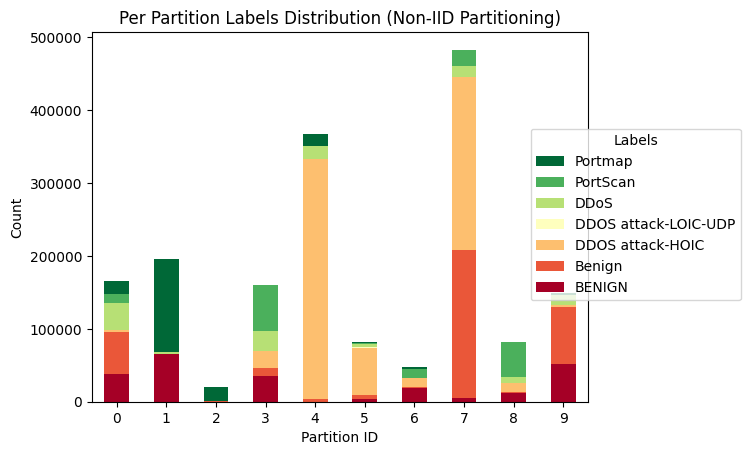

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


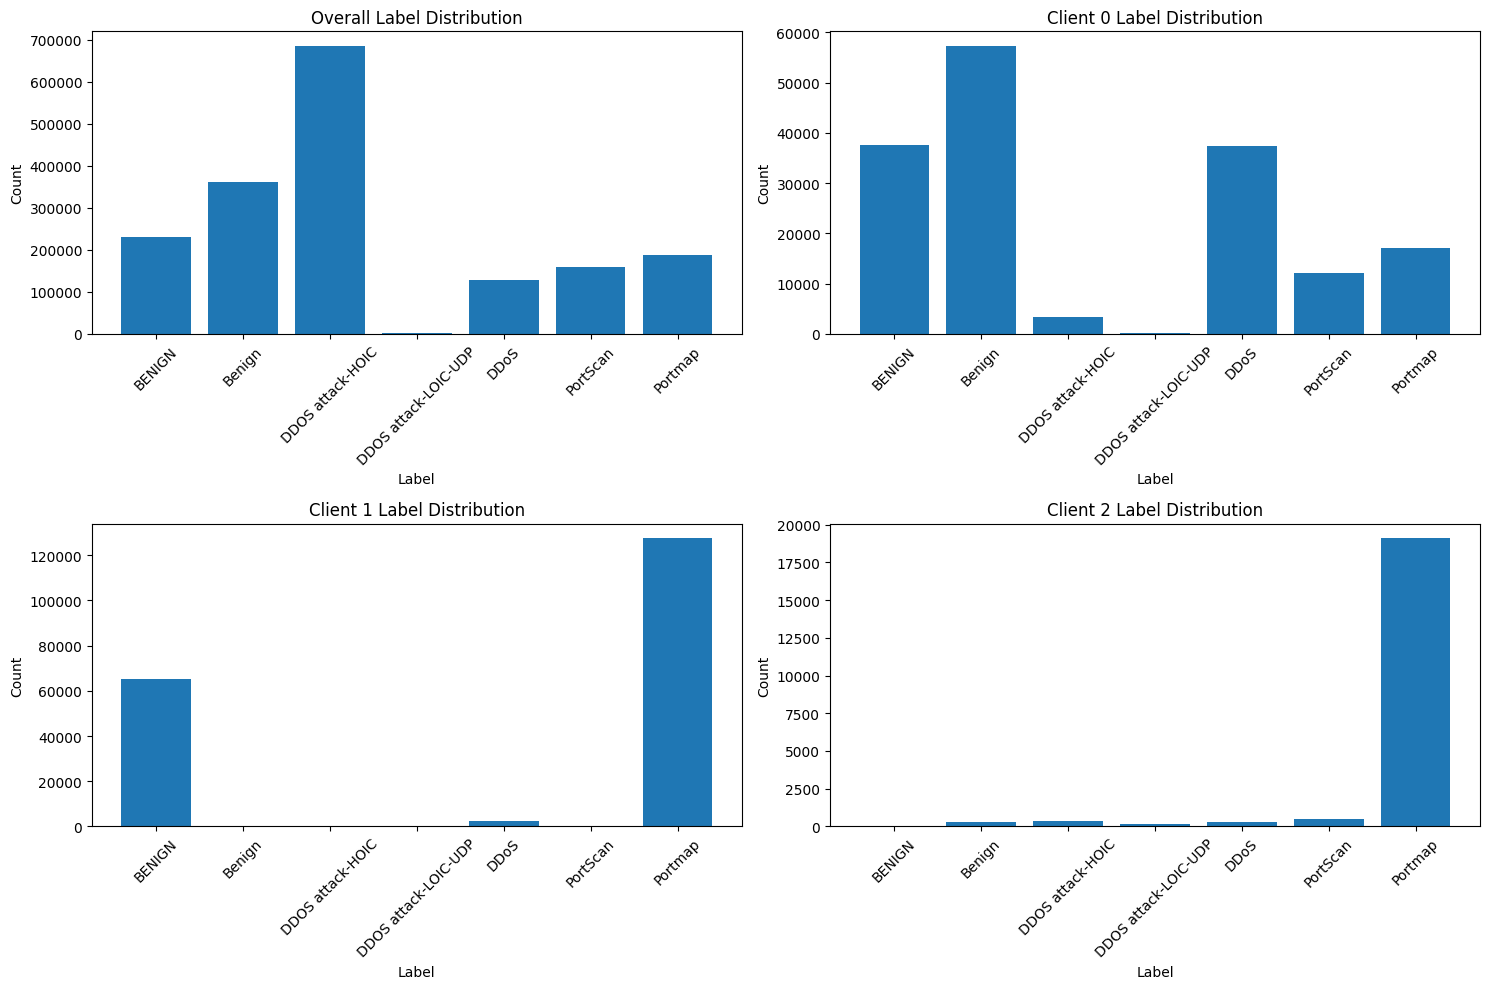


非IID程度分析:
客户端 0: {'BENIGN': np.int64(37588), 'Benign': np.int64(57362), 'DDOS attack-HOIC': np.int64(3459), 'DDOS attack-LOIC-UDP': np.int64(149), 'DDoS': np.int64(37455), 'PortScan': np.int64(12211), 'Portmap': np.int64(17060)}
客户端 1: {'BENIGN': np.int64(65134), 'Benign': np.int64(386), 'DDOS attack-HOIC': np.int64(72), 'DDOS attack-LOIC-UDP': np.int64(1), 'DDoS': np.int64(2485), 'PortScan': np.int64(1), 'Portmap': np.int64(127486)}
客户端 2: {'BENIGN': np.int64(32), 'Benign': np.int64(318), 'DDOS attack-HOIC': np.int64(384), 'DDOS attack-LOIC-UDP': np.int64(157), 'DDoS': np.int64(274), 'PortScan': np.int64(501), 'Portmap': np.int64(19095)}
客户端 3: {'BENIGN': np.int64(35012), 'Benign': np.int64(11464), 'DDOS attack-HOIC': np.int64(22838), 'DDOS attack-LOIC-UDP': np.int64(42), 'DDoS': np.int64(28153), 'PortScan': np.int64(62997), 'Portmap': np.int64(82)}
客户端 4: {'BENIGN': np.int64(90), 'Benign': np.int64(3105), 'DDOS attack-HOIC': np.int64(329249), 'DDOS attack-LOIC-UDP': np.int64(7), 'DD

In [27]:
from flwr_datasets import FederatedDataset
from flwr_datasets.partitioner import DirichletPartitioner
from flwr_datasets.visualization import plot_label_distributions
from datasets import ClassLabel
import numpy as np
import matplotlib.pyplot as plt

# 创建 FederatedDataset，使用非IID分区（Dirichlet分布）
fds = FederatedDataset(
    dataset="fycq22/CICIDS-171819",
    partitioners={
        "train": DirichletPartitioner(
            num_partitions=10,  # 10个客户端
            partition_by="Label",  # 按标签分区
            alpha=0.3,  # 控制非IID程度（值越小，差异越大）
            seed=42,  # 随机种子
            min_partition_size=0,  # 最小分区大小
        )
    },
)

# 加载完整的 train split（未分区）
full_train = fds.load_split("train")

# 转换标签列为ClassLabel类型
print("转换前标签类型:", full_train.features["Label"])

# 获取所有唯一标签
unique_labels = sorted(set(full_train["Label"]))
class_label = ClassLabel(names=unique_labels)

# 应用转换
full_train = full_train.cast_column("Label", class_label)
print("转换后标签类型:", full_train.features["Label"])

# 获取标签特征对象
label_feature = full_train.features["Label"]

# 从 train split 中划分出唯一的 centralized test
dataset = full_train.train_test_split(test_size=0.2, seed=42, stratify_by_column="Label")
centralized_test = dataset["test"]

# 加载第一个 partition (client 0 的训练集)
partition = fds.load_partition(0, "train")

print(f"Partition size (client 0 train): {len(partition)}")
print(f"Centralized test size: {len(centralized_test)}")

# 验证标签分布（使用整数表示）
# 确保标签是字符串：如果已经是整数，则转换为字符串
def convert_to_str(x):
    if isinstance(x, int):
        return str(x)
    return x

# 将训练集和测试集的标签转换为字符串
train_labels_str = [convert_to_str(label) for label in dataset["train"]["Label"]]
test_labels_str = [convert_to_str(label) for label in centralized_test["Label"]]

# 使用ClassLabel的str2int方法将字符串标签转换为整数
train_labels = [label_feature.str2int(label) for label in train_labels_str]
test_labels = [label_feature.str2int(label) for label in test_labels_str]

print(f"训练集标签分布: {np.unique(train_labels, return_counts=True)}")
print(f"测试集标签分布: {np.unique(test_labels, return_counts=True)}")

# 获取分区器
partitioner = fds.partitioners["train"]

# 可视化标签分布（非IID分区）
fig, ax, df = plot_label_distributions(
    partitioner,
    label_name="Label",  # 使用你的标签列名
    plot_type="bar",
    size_unit="absolute",
    partition_id_axis="x",
    legend=True,
    verbose_labels=True,
    title="Per Partition Labels Distribution (Non-IID Partitioning)"
)

# 自定义图表
plt.figure(figsize=(15, 10))

# 1. 整体标签分布
plt.subplot(2, 2, 1)
# 确保标签是字符串
full_train_labels_str = [convert_to_str(label) for label in full_train["Label"]]
# 使用ClassLabel的str2int方法将字符串标签转换为整数
label_indices = [label_feature.str2int(label) for label in full_train_labels_str]
label_counts = np.bincount(label_indices)
plt.bar(range(len(label_counts)), label_counts)
plt.title("Overall Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(range(len(unique_labels)), unique_labels, rotation=45)

# 2. 客户端0的标签分布
plt.subplot(2, 2, 2)
# 确保标签是字符串
client0_labels_str = [convert_to_str(label) for label in partition["Label"]]
# 使用ClassLabel的str2int方法将字符串标签转换为整数
client0_labels = [label_feature.str2int(label) for label in client0_labels_str]
client0_counts = np.bincount(client0_labels)
plt.bar(range(len(client0_counts)), client0_counts)
plt.title("Client 0 Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(range(len(unique_labels)), unique_labels, rotation=45)

# 3. 客户端1的标签分布（作为对比）
plt.subplot(2, 2, 3)
client1_partition = fds.load_partition(1, "train")
# 确保标签是字符串
client1_labels_str = [convert_to_str(label) for label in client1_partition["Label"]]
# 使用ClassLabel的str2int方法将字符串标签转换为整数
client1_labels = [label_feature.str2int(label) for label in client1_labels_str]
client1_counts = np.bincount(client1_labels)
plt.bar(range(len(client1_counts)), client1_counts)
plt.title("Client 1 Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(range(len(unique_labels)), unique_labels, rotation=45)

# 4. 客户端2的标签分布（作为对比）
plt.subplot(2, 2, 4)
client2_partition = fds.load_partition(2, "train")
# 确保标签是字符串
client2_labels_str = [convert_to_str(label) for label in client2_partition["Label"]]
# 使用ClassLabel的str2int方法将字符串标签转换为整数
client2_labels = [label_feature.str2int(label) for label in client2_labels_str]
client2_counts = np.bincount(client2_labels)
plt.bar(range(len(client2_counts)), client2_counts)
plt.title("Client 2 Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(range(len(unique_labels)), unique_labels, rotation=45)

plt.tight_layout()
plt.show()

# 额外：计算并显示非IID程度
print("\n非IID程度分析:")
for i in range(10):
    client_data = fds.load_partition(i, "train")
    # 确保标签是字符串
    client_labels_str = [convert_to_str(label) for label in client_data["Label"]]
    # 使用ClassLabel的str2int方法将字符串标签转换为整数
    client_labels = [label_feature.str2int(label) for label in client_labels_str]
    client_counts = np.bincount(client_labels)
    print(f"客户端 {i}: {dict(zip(unique_labels, client_counts))}")

## Use with PyTorch/NumPy/TensorFlow

For more detailed instructions, go to:

* [how-to-use-with-pytorch](https://flower.ai/docs/datasets/how-to-use-with-pytorch.html)

* [how-to-use-with-numpy](https://flower.ai/docs/datasets/how-to-use-with-numpy.html)

* [how-to-use-with-tensorflow](https://flower.ai/docs/datasets/how-to-use-with-tensorflow.html)

### PyTorch

Transform the `Dataset` into the `DataLoader`, use the `PyTorch transforms` (`Compose` and all the others are possible).

In [ ]:
! pip install -q torch torchvision

In [ ]:
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

transforms = ToTensor()


def apply_transforms(batch):
    # For CIFAR-10 the "img" column contains the images we want to apply the transforms to
    batch["img"] = [transforms(img) for img in batch["img"]]
    return batch


partition_torch = partition.with_transform(apply_transforms)
dataloader = DataLoader(partition_torch, batch_size=64)

The `Dataloader` created this way does not return a `Tuple` when iterating over it but a `Dict` with the names of the columns as keys and features as values. Look below for an example.

In [ ]:
for batch in dataloader:
    print(f"Return type when iterating over a dataloader: {type(batch)}")
    print(batch["img"].shape)
    print(batch["label"].shape)
    break

Return type when iterating over dataloader: <class 'dict'>
torch.Size([64, 3, 32, 32])
torch.Size([64])


### NumPy

NumPy can be used as input to the TensorFlow and scikit-learn models. The transformation is very simple.

In [ ]:
partition_np = partition.with_format("numpy")
X_train, y_train = partition_np["img"], partition_np["label"]

### TensorFlow Dataset

Transformation to TensorFlow Dataset is a one-liner.

In [ ]:
! pip install -q tensorflow

In [ ]:
tf_dataset = partition.to_tf_dataset(
    columns="img", label_cols="label", batch_size=64, shuffle=True
)

## Final remarks

Congratulations, you now know the basics of Flower Datasets and are ready to perform basic dataset preparation for Federated Learning.

## Next

This is the first quickstart tutorial from the Flower Datasets series. See other tutorials:

* [Use Partitioners](https://flower.ai/docs/datasets/tutorial-use-partitioners.html)

* [Visualize Label Distribution](https://flower.ai/docs/datasets/tutorial-visualize-label-distribution.html)